In [53]:
# Importation des librairies de base

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import gaussian_kde    
from scipy.stats import probplot
from scipy.stats import ttest_rel

import wrds
from scipy import stats
from scipy.stats import skew, kurtosis
import warnings

from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')


from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

In [54]:
USD = pd.read_csv('USD.csv')

USD['date'] = pd.to_datetime(USD['date'])

USD

,date,dexalus,dexcaus,dexjpus,dexnzus,dexukus
0,1971-01-04,0.898715,1.0109,357.73,0.897827,0.417746
1,1971-01-05,0.898311,1.0102,357.81,0.897424,0.417554
2,1971-01-06,0.897666,1.0106,357.86,0.896781,0.417240
3,1971-01-07,0.897827,1.0148,357.87,0.896861,0.417310
4,1971-01-08,0.898957,1.0154,357.82,0.896539,0.417153
...,...,...,...,...,...,...
14110,2025-02-03,1.618909,1.4601,154.68,1.789229,0.807168
14111,2025-02-04,1.598210,1.4318,154.56,1.769912,0.800833
14112,2025-02-05,1.588310,1.4280,152.33,1.755310,0.798977
14113,2025-02-06,1.592610,1.4314,152.04,1.763668,0.804182


In [55]:
USD.columns = ['date', 'AUD','CAD','JPY','NZD','GBP']

USD

,date,AUD,CAD,JPY,NZD,GBP
0,1971-01-04,0.898715,1.0109,357.73,0.897827,0.417746
1,1971-01-05,0.898311,1.0102,357.81,0.897424,0.417554
2,1971-01-06,0.897666,1.0106,357.86,0.896781,0.417240
3,1971-01-07,0.897827,1.0148,357.87,0.896861,0.417310
4,1971-01-08,0.898957,1.0154,357.82,0.896539,0.417153
...,...,...,...,...,...,...
14110,2025-02-03,1.618909,1.4601,154.68,1.789229,0.807168
14111,2025-02-04,1.598210,1.4318,154.56,1.769912,0.800833
14112,2025-02-05,1.588310,1.4280,152.33,1.755310,0.798977
14113,2025-02-06,1.592610,1.4314,152.04,1.763668,0.804182


In [82]:
# Nettoyage et filtrage de la période + Conversion en données mensuelles
USD = USD.dropna()

# Convertir en données mensuelles (dernier jour de chaque mois)
USD['year_month'] = USD['date'].dt.to_period('M')
USD_monthly = USD.groupby('year_month').last().reset_index()
USD_monthly['date'] = USD_monthly['year_month'].dt.to_timestamp()
USD_monthly = USD_monthly.drop('year_month', axis=1)

# Filtrer la période 2006-01-01 à 2024-12-31
USD_monthly = USD_monthly[(USD_monthly['date'] >= '2006-01-01') & (USD_monthly['date'] <= '2024-12-31')].copy()

print(f"\nDonnées originales: {len(USD)} observations quotidiennes")
print(f"Données mensuelles: {len(USD_monthly)} observations mensuelles")
print(f"\nDébut: {USD_monthly['date'].min()}")
print(f"Fin : {USD_monthly['date'].max()}\n")

# Renommer USD pour utiliser les données mensuelles
USD = USD_monthly.copy()

USD


Données originales: 227 observations quotidiennes
Données mensuelles: 227 observations mensuelles

Début: 2006-02-01 00:00:00
Fin : 2024-12-01 00:00:00



,date,AUD,CAD,JPY,NZD,GBP,AUD_return,CAD_return,JPY_return,NZD_return,GBP_return
0,2006-02-01,1.345895,1.1379,115.82,1.507386,0.570158,0.018931,-0.004997,-0.009111,0.033062,0.015894
1,2006-03-01,1.395673,1.1670,117.48,1.622323,0.574944,0.036318,0.025252,0.014231,0.073482,0.008359
2,2006-04-01,1.317003,1.1203,113.79,1.570352,0.548847,-0.058019,-0.040840,-0.031913,-0.032560,-0.046452
3,2006-05-01,1.329964,1.1027,112.26,1.570845,0.533846,0.009794,-0.015835,-0.013537,0.000314,-0.027713
4,2006-06-01,1.347164,1.1150,114.51,1.638002,0.540804,0.012850,0.011093,0.019845,0.041863,0.012949
...,...,...,...,...,...,...,...,...,...,...,...
222,2024-08-01,1.478197,1.3493,145.95,1.602051,0.761499,-0.034590,-0.022932,-0.029901,-0.048414,-0.022487
223,2024-09-01,1.442169,1.3511,143.25,1.571586,0.746324,-0.024675,0.001333,-0.018673,-0.019199,-0.020128
224,2024-10-01,1.526718,1.3939,152.35,1.680390,0.777847,0.056972,0.031186,0.061589,0.066941,0.041369
225,2024-11-01,1.535391,1.4014,150.41,1.691189,0.787464,0.005665,0.005366,-0.012816,0.006406,0.012287


In [57]:
# 1c) Conversion en rendements 

# Calcul des rendements logarithmiques
currencies = ['AUD', 'CAD', 'JPY', 'NZD', 'GBP']

for curr in currencies:
    USD[f'{curr}_return'] = np.log(USD[curr] / USD[curr].shift(1))

# Suppression de la première ligne avec NaN
USD_returns = USD.dropna().copy()

print(f"Nombre d'observations: {len(USD_returns)}")
print(f"\nAperçu des rendements:")
USD_returns[['date'] + [f'{c}_return' for c in currencies]].head(10)

Nombre d'observations: 227

Aperçu des rendements:


,date,AUD_return,CAD_return,JPY_return,NZD_return,GBP_return
421,2006-02-01,0.018931,-0.004997,-0.009111,0.033062,0.015894
422,2006-03-01,0.036318,0.025252,0.014231,0.073482,0.008359
423,2006-04-01,-0.058019,-0.040840,-0.031913,-0.032560,-0.046452
424,2006-05-01,0.009794,-0.015835,-0.013537,0.000314,-0.027713
425,2006-06-01,0.012850,0.011093,0.019845,0.041863,0.012949
426,2006-07-01,-0.031951,0.014159,-0.000611,-0.009780,-0.010437
427,2006-08-01,0.004446,-0.021722,0.025110,-0.059813,-0.017980
428,2006-09-01,0.022398,0.007652,0.005439,0.002294,0.016323
429,2006-10-01,-0.037100,0.006792,-0.009966,-0.026745,-0.019472
430,2006-11-01,-0.019567,0.016431,-0.010931,-0.021097,-0.031413


### 1d) Statistiques Descriptives et Graphiques

In [84]:
# Statistiques descriptives pour les rendements
return_cols = [f'{c}_return' for c in currencies]
stats_df = USD_returns[return_cols].describe()

# Ajout de statistiques supplémentaires
stats_df.loc['skewness'] = USD_returns[return_cols].apply(skew)
stats_df.loc['kurtosis'] = USD_returns[return_cols].apply(kurtosis)

stats_df

,AUD_return,CAD_return,JPY_return,NZD_return,GBP_return
count,227.000000,227.000000,227.000000,227.000000,227.000000
mean,0.000891,0.001015,0.001310,0.000895,0.001555
std,0.036235,0.025754,0.027756,0.038616,0.025748
min,-0.088366,-0.085832,-0.075052,-0.123642,-0.087979
25%,-0.022898,-0.014477,-0.015629,-0.025017,-0.016751
50%,0.001296,0.000561,-0.000611,-0.000834,0.000785
75%,0.021490,0.015540,0.017546,0.024808,0.015554
max,0.184246,0.137416,0.084550,0.140173,0.096575
skewness,0.612682,0.589618,0.126925,0.331059,0.384645
kurtosis,2.463279,3.695835,0.608462,1.066869,1.399988


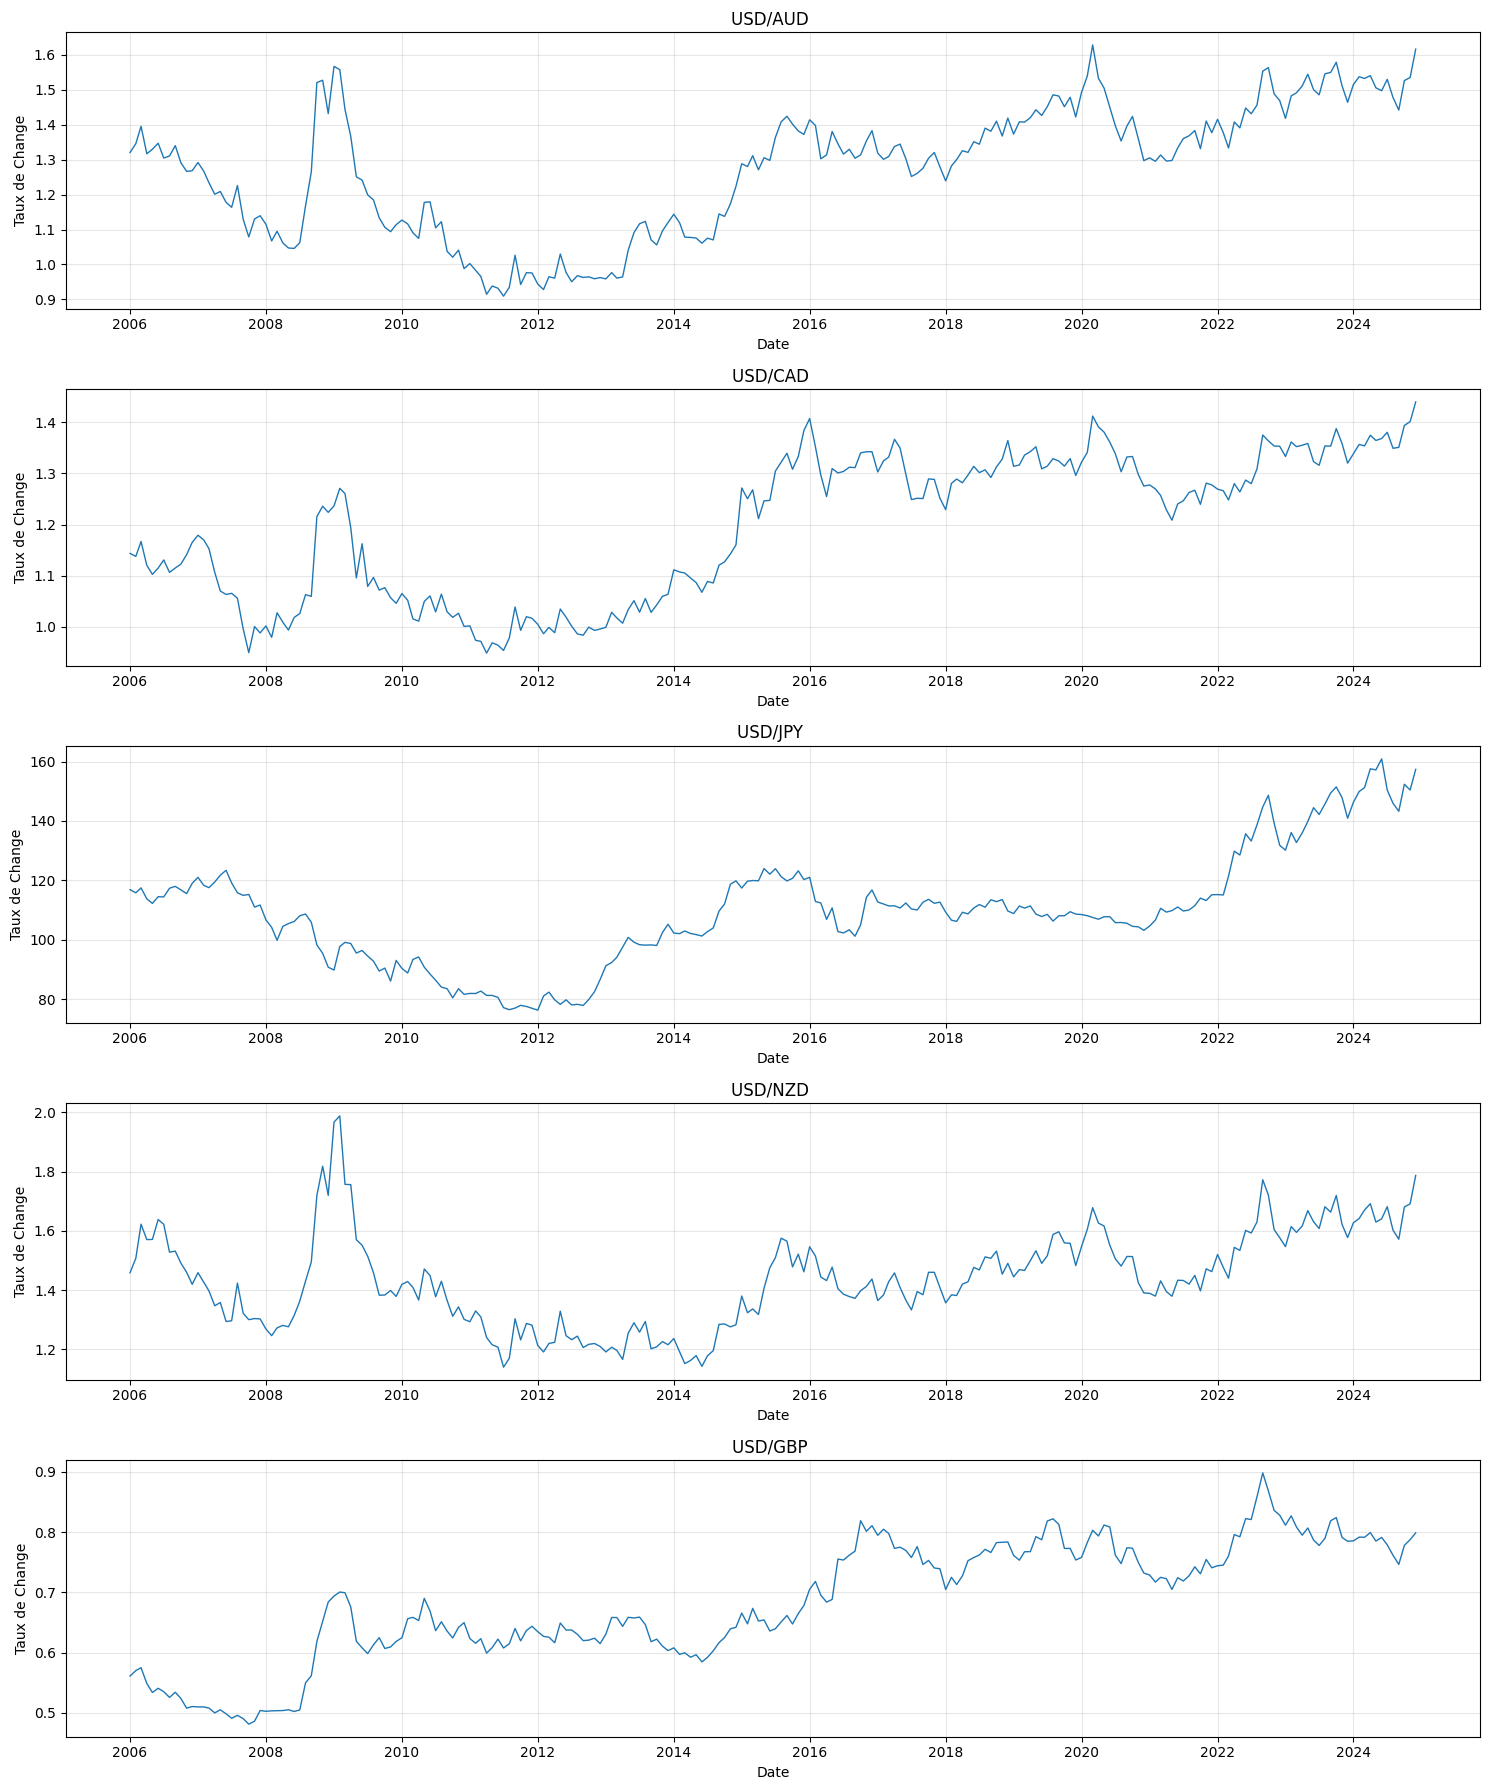

In [59]:
# Graphiques des séries temporelles des taux de change
fig, axes = plt.subplots(5, 1, figsize=(15, 18))

for i, curr in enumerate(currencies):
    axes[i].plot(USD['date'], USD[curr], linewidth=1)
    axes[i].set_title(f'USD/{curr} ')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Taux de Change')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

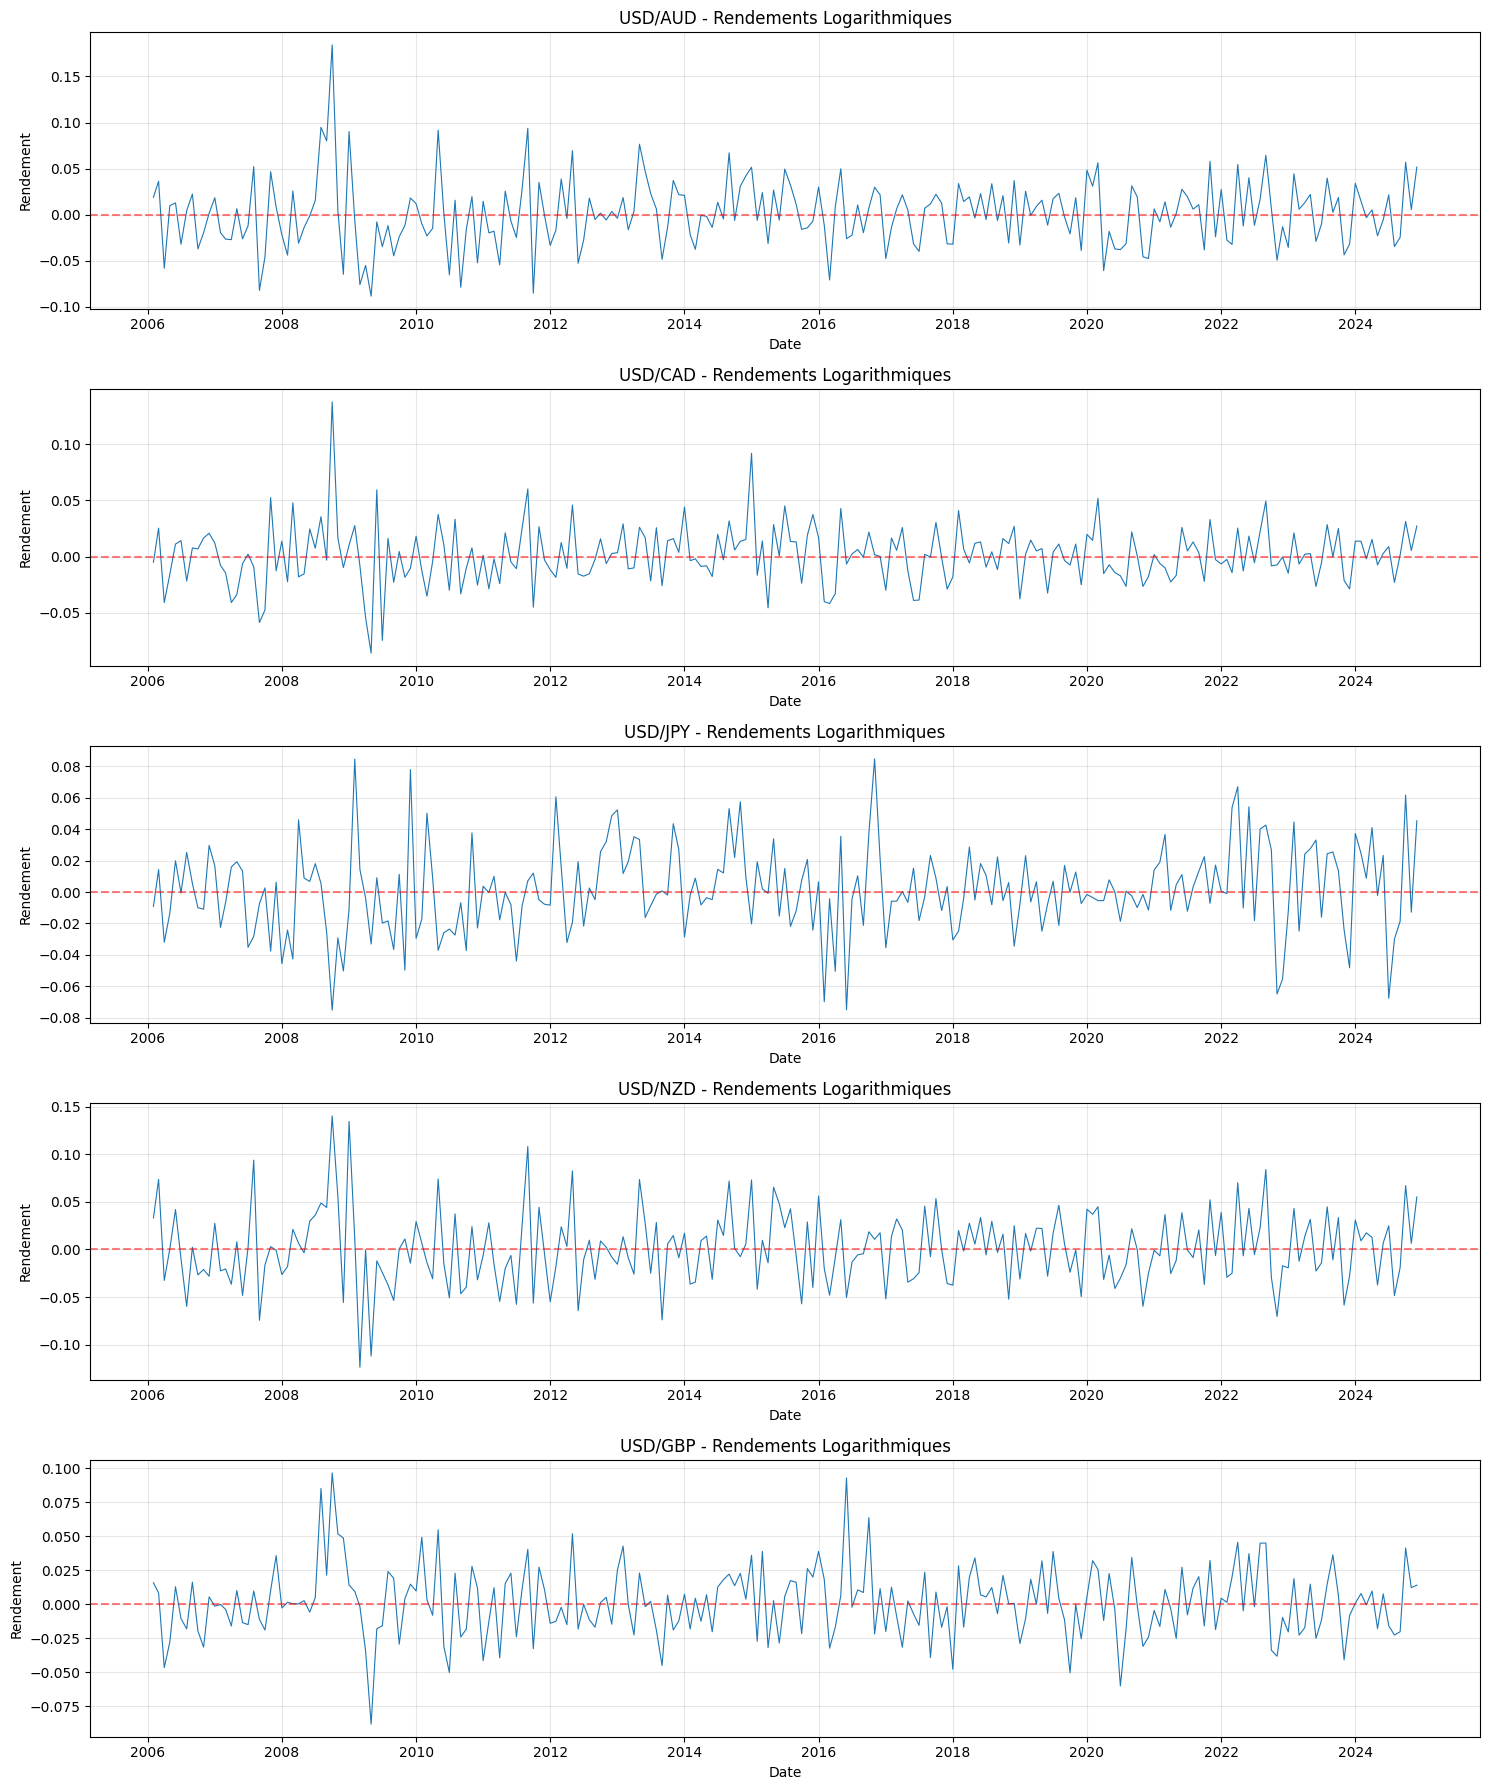

In [60]:
# Graphiques des séries temporelles des rendements
fig, axes = plt.subplots(5, 1, figsize=(15, 18))

for i, curr in enumerate(currencies):
    axes[i].plot(USD_returns['date'], USD_returns[f'{curr}_return'], linewidth=0.8)
    axes[i].set_title(f'USD/{curr} - Rendements Logarithmiques')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Rendement')
    axes[i].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

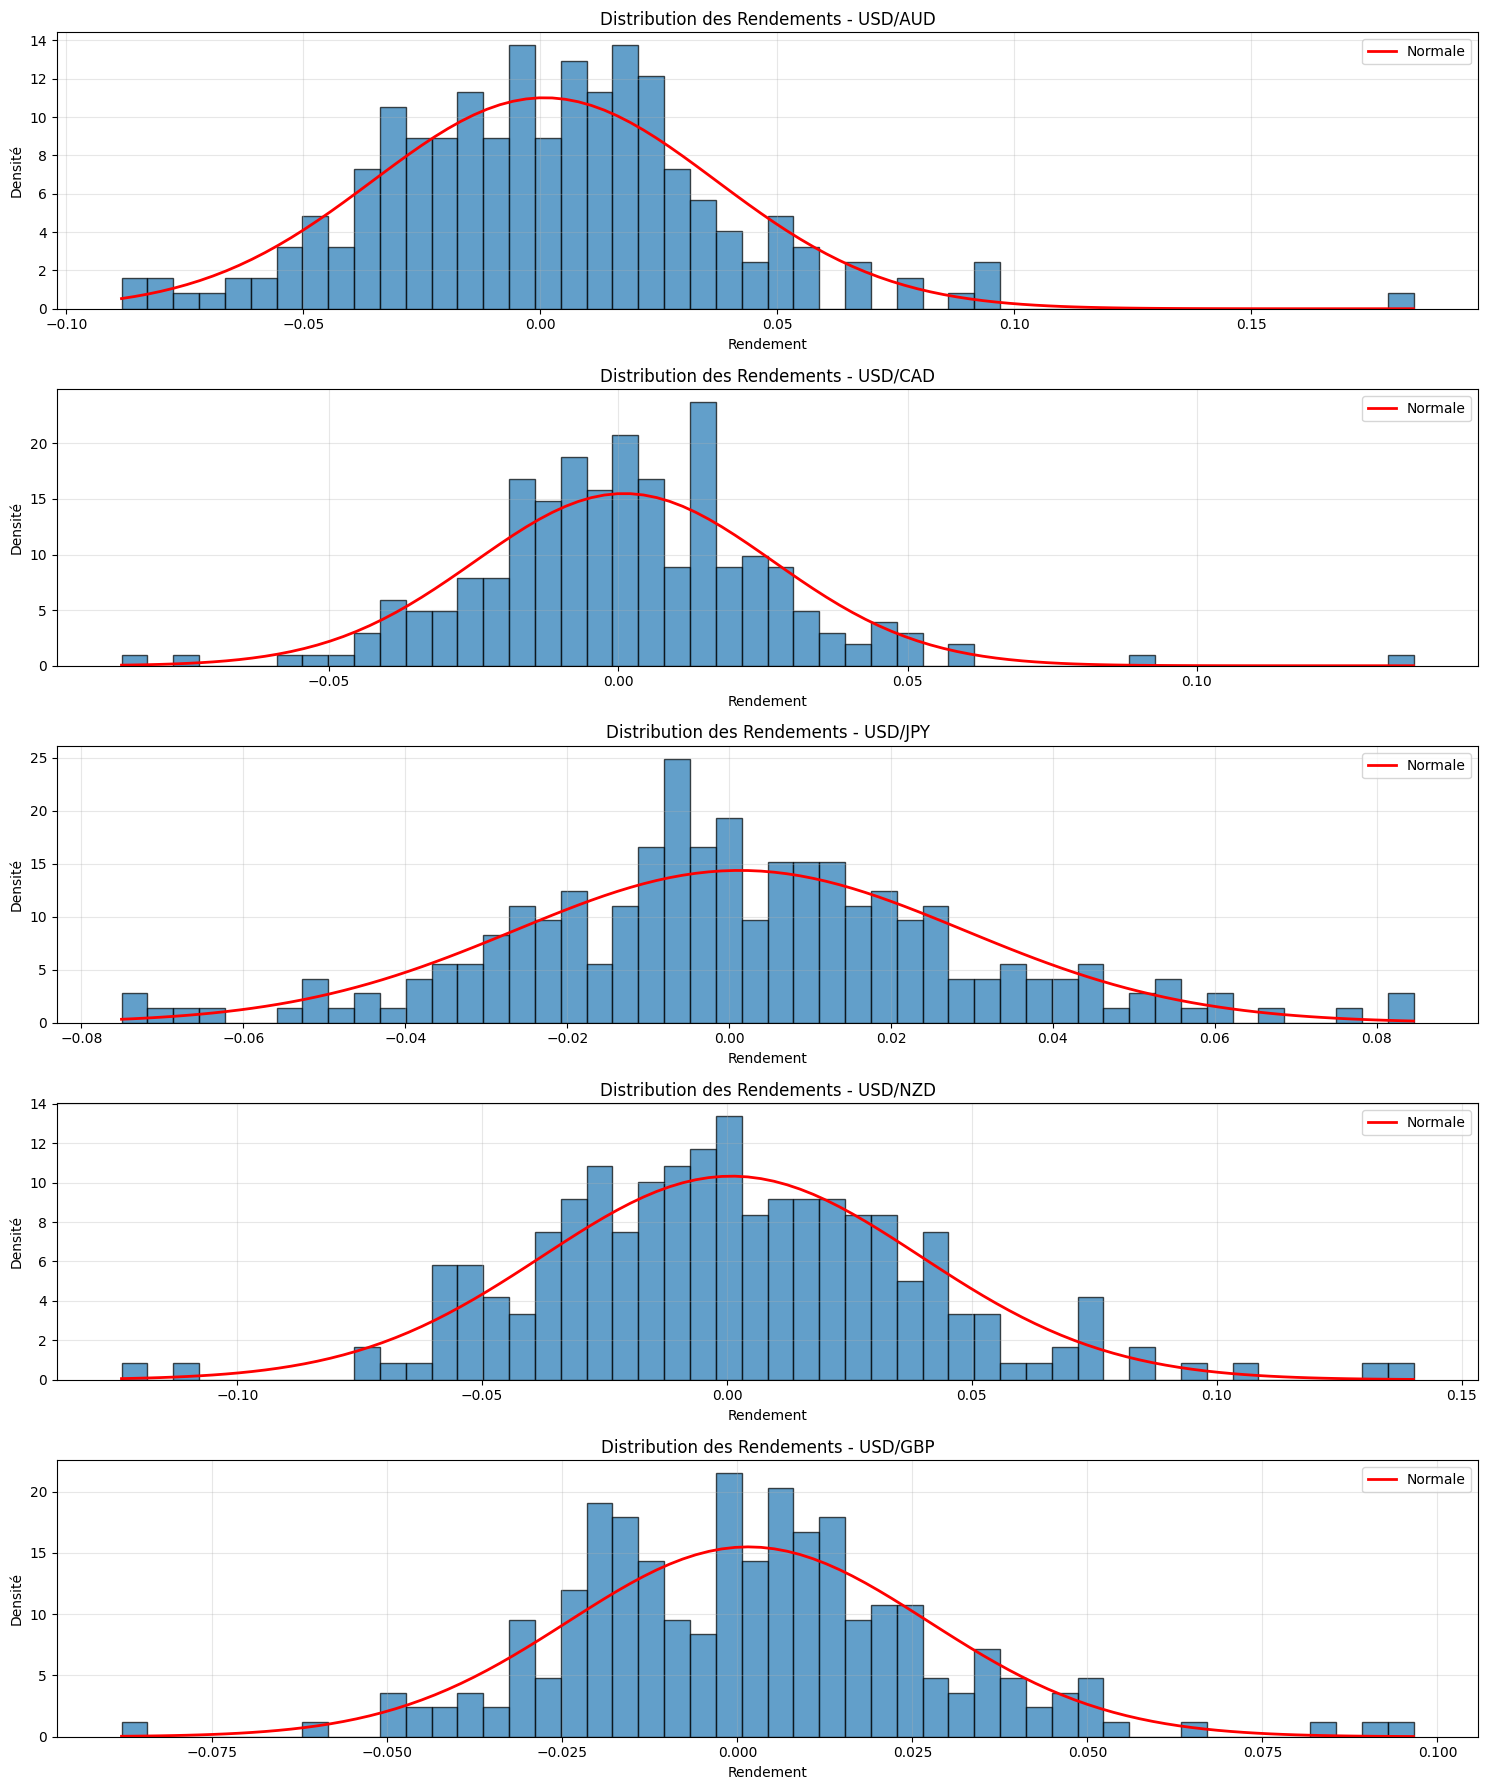

In [61]:
# Histogrammes et distributions des rendements
fig, axes = plt.subplots(5, 1, figsize=(15, 18))

for i, curr in enumerate(currencies):
    data = USD_returns[f'{curr}_return'].dropna()
    axes[i].hist(data, bins=50, density=True, alpha=0.7, edgecolor='black')
    
    # Ajout d'une courbe normale pour comparaison
    mu, sigma = data.mean(), data.std()
    x = np.linspace(data.min(), data.max(), 100)
    axes[i].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normale')
    
    axes[i].set_title(f'Distribution des Rendements - USD/{curr}')
    axes[i].set_xlabel('Rendement')
    axes[i].set_ylabel('Densité')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Analyse en Composantes Principales (ACP)

In [62]:
# 2a) Fonction ACP personnalisée

def custom_pca(data, standardize=True):
    
    # Convertir en array numpy si nécessaire
    if isinstance(data, pd.DataFrame):
        X = data.values
        columns = data.columns
    else:
        X = np.array(data)
        columns = [f'Var{i}' for i in range(X.shape[1])]
    
    # Centrer les données
    X_centered = X - np.mean(X, axis=0)
    
    # Standardiser si demandé
    if standardize:
        X_std = np.std(X, axis=0, ddof=1)
        X_standardized = X_centered / X_std
        data_for_cov = X_standardized
    else:
        X_standardized = X_centered
        data_for_cov = X_centered
    
    # Calculer la matrice de variance-covariance
    n = X.shape[0]
    cov_matrix = (data_for_cov.T @ data_for_cov) / (n - 1)
    
    # Calculer les valeurs propres et vecteurs propres
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    
    # Trier par ordre décroissant des valeurs propres
    sorted_idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_idx]
    eigenvectors = eigenvectors[:, sorted_idx]
    
    # Calculer les composantes principales
    principal_components = data_for_cov @ eigenvectors
    
    # Calculer la variance expliquée
    total_variance = np.sum(eigenvalues)
    explained_variance_ratio = eigenvalues / total_variance
    
    return {
        'data_centered': X_centered,
        'data_standardized': X_standardized,
        'cov_matrix': cov_matrix,
        'eigenvalues': eigenvalues,
        'eigenvectors': eigenvectors,
        'principal_components': principal_components,
        'explained_variance': eigenvalues,
        'explained_variance_ratio': explained_variance_ratio,
        'columns': columns
    }

In [85]:
# Application de l'ACP sur les rendements des devises
returns_data = USD_returns[return_cols]

# Exécuter l'ACP (avec standardisation)
pca_results = custom_pca(returns_data, standardize=True)

In [87]:
# 2b) Matrice de Variance-Covariance

cov_df = pd.DataFrame(pca_results['cov_matrix'], 
                      columns=currencies, 
                      index=currencies)

cov_df

,AUD,CAD,JPY,NZD,GBP
AUD,1.000000,0.760662,0.158671,0.847940,0.588260
CAD,0.760662,1.000000,0.084646,0.673825,0.576636
JPY,0.158671,0.084646,1.000000,0.166124,0.080394
NZD,0.847940,0.673825,0.166124,1.000000,0.572785
GBP,0.588260,0.576636,0.080394,0.572785,1.000000


In [93]:
# 2c) Valeurs Propres

eigenvalues_df = pd.DataFrame({
    'Composante': [f'CP{i+1}' for i in range(len(pca_results['eigenvalues']))],
    'Valeur Propre': pca_results['eigenvalues']
})

eigenvalues_df

,Composante,Valeur Propre
0,CP1,3.051705
1,CP2,0.977773
2,CP3,0.501680
3,CP4,0.331506
4,CP5,0.137336


In [94]:
# 2c) Vecteurs Propres

eigenvectors_df = pd.DataFrame(
    pca_results['eigenvectors'],
    columns=[f'CP{i+1}' for i in range(len(pca_results['eigenvalues']))],
    index=currencies
)

eigenvectors_df

,CP1,CP2,CP3,CP4,CP5
AUD,-0.531509,0.019319,-0.304227,0.165434,0.772789
CAD,-0.494659,0.117226,-0.167643,-0.811178,-0.235492
JPY,-0.120418,-0.985687,0.082638,-0.083858,-0.007696
NZD,-0.514657,-0.004146,-0.299983,0.546197,-0.588889
GBP,-0.439816,0.119534,0.884603,0.096224,0.022161


In [98]:
### 2d) Valeurs des Composantes Principales (PC Scores)

# Créer un DataFrame avec les composantes principales
pc_df = pd.DataFrame(
    pca_results['principal_components'],
    columns=[f'CP{i+1}' for i in range(len(pca_results['eigenvalues']))],
    index=USD_returns['date'].values
)

pc_df

,CP1,CP2,CP3,CP4,CP5
2006-02-01,-0.777595,0.415446,0.099428,0.811780,-0.035591
2006-03-01,-2.124870,-0.305837,-0.746843,0.411441,-0.570735
2006-04-01,3.078100,0.738663,-0.721324,0.497135,-0.395598
2006-05-01,0.765172,0.319504,-1.010308,0.498634,0.331726
2006-06-01,-1.190028,-0.557453,-0.037598,0.303239,-0.457194
...,...,...,...,...,...
2024-08-01,2.183676,0.874172,-0.082075,-0.100704,0.202174
2024-09-01,1.093799,0.598965,-0.435762,-0.431620,-0.254841
2024-10-01,-3.223979,-1.795680,0.367059,0.206576,-0.069470
2024-11-01,-0.349084,0.573236,0.215474,0.045486,-0.008861


In [101]:
# 2e) Variances et Proportions de Variance Expliquée

# Créer un tableau récapitulatif
variance_df = pd.DataFrame({
    'Composante': [f'CP{i+1}' for i in range(len(pca_results['eigenvalues']))],
    'Valeur Propre': pca_results['eigenvalues'],
    'Variance Expliquée': pca_results['explained_variance'],
    'Proportion Variance (%)': pca_results['explained_variance_ratio'] * 100,
    'Variance Cumulée (%)': np.cumsum(pca_results['explained_variance_ratio']) * 100
})
 
variance_df

,Composante,Valeur Propre,Variance Expliquée,Proportion Variance (%),Variance Cumulée (%)
0,CP1,3.051705,3.051705,61.034108,61.034108
1,CP2,0.977773,0.977773,19.555456,80.589564
2,CP3,0.501680,0.501680,10.033596,90.623161
3,CP4,0.331506,0.331506,6.630110,97.253271
4,CP5,0.137336,0.137336,2.746729,100.000000


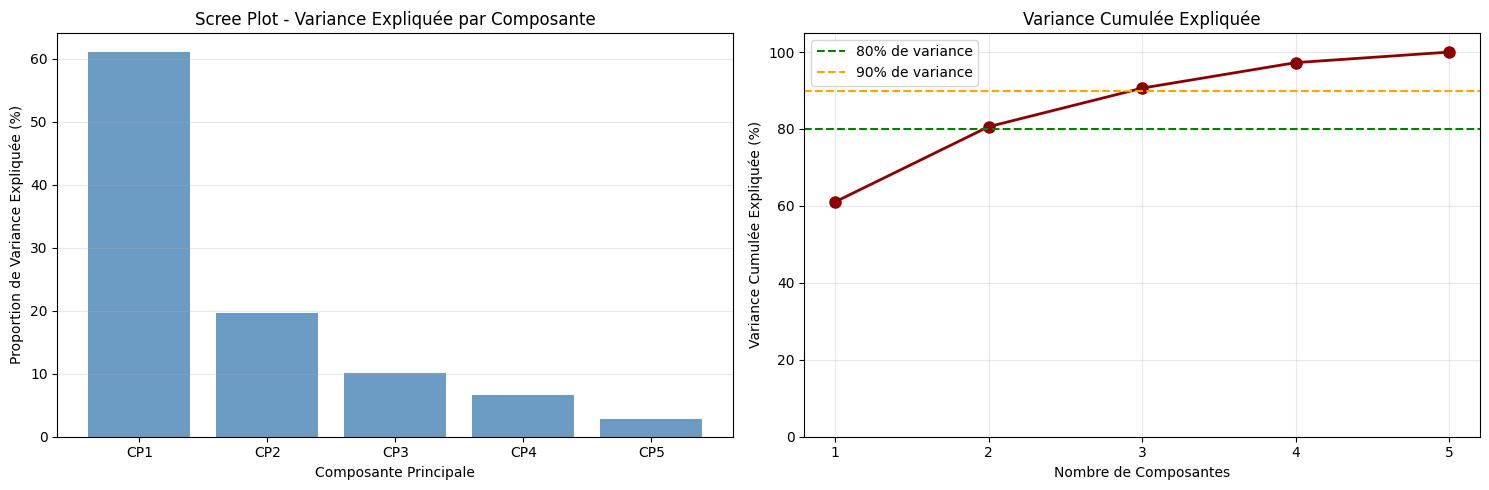

In [103]:
# Graphique de la variance expliquée
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Variance expliquée par composante
x_pos = np.arange(len(pca_results['eigenvalues']))
ax1.bar(x_pos, pca_results['explained_variance_ratio'] * 100, alpha=0.8, color='steelblue')
ax1.set_xlabel('Composante Principale')
ax1.set_ylabel('Proportion de Variance Expliquée (%)')
ax1.set_title('Scree Plot - Variance Expliquée par Composante')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([f'CP{i+1}' for i in range(len(pca_results['eigenvalues']))])
ax1.grid(True, alpha=0.3, axis='y')

# Variance cumulée
ax2.plot(x_pos, np.cumsum(pca_results['explained_variance_ratio']) * 100, 
         marker='o', linewidth=2, markersize=8, color='darkred')
ax2.axhline(y=80, color='g', linestyle='--', label='80% de variance')
ax2.axhline(y=90, color='orange', linestyle='--', label='90% de variance')
ax2.set_xlabel('Nombre de Composantes')
ax2.set_ylabel('Variance Cumulée Expliquée (%)')
ax2.set_title('Variance Cumulée Expliquée')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f'{i+1}' for i in range(len(pca_results['eigenvalues']))])
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 105])

plt.tight_layout()
plt.show()

In [107]:
# Chargement de TOUS les facteurs macroéconomiques (3 initiaux + 2 nouveaux)
DXY = pd.read_csv('DXY.csv')
VIX = pd.read_csv('VIX.csv')
WTI = pd.read_csv('WTI.csv')
T10Y = pd.read_csv('10Y.csv')  
HYS = pd.read_csv('HYS.csv') 

# Afficher les informations sur chaque facteur
factors_info = [
    (DXY, 'DXY'),
    (VIX, 'VIX'),
    (WTI, 'WTI'),
    (T10Y, 'T10Y'),
    (HYS, 'HYS')
]

for df, code in factors_info:
    print(f"\n{code}:")
    print(f"Observations: {len(df)}")
    print(f"Période: {df.iloc[0, 0]} à {df.iloc[-1, 0]}")


DXY:
Observations: 5200
Période: 2006-01-02 à 2025-12-05

VIX:
Observations: 5203
Période: 2006-01-03 à 2025-12-11

WTI:
Observations: 5200
Période: 2006-01-03 à 2025-12-08

T10Y:
Observations: 5204
Période: 2006-01-03 à 2025-12-12

HYS:
Observations: 5270
Période: 2006-01-03 à 2025-12-11


## 3. Construction du Modèle Factoriel

In [109]:
# 3b) Préparation des Données des Facteurs (5 facteurs)

# Re-charger les facteurs et convertir les dates proprement
DXY = pd.read_csv('DXY.csv')
VIX = pd.read_csv('VIX.csv')
WTI = pd.read_csv('WTI.csv')
T10Y = pd.read_csv('10Y.csv')
HYS = pd.read_csv('HYS.csv')

# Convertir les dates et renommer
DXY['observation_date'] = pd.to_datetime(DXY['observation_date'])
VIX['observation_date'] = pd.to_datetime(VIX['observation_date'])
WTI['observation_date'] = pd.to_datetime(WTI['observation_date'])
T10Y['observation_date'] = pd.to_datetime(T10Y['observation_date'])
HYS['observation_date'] = pd.to_datetime(HYS['observation_date'])

DXY.rename(columns={'observation_date': 'date'}, inplace=True)
VIX.rename(columns={'observation_date': 'date'}, inplace=True)
WTI.rename(columns={'observation_date': 'date'}, inplace=True)
T10Y.rename(columns={'observation_date': 'date'}, inplace=True)
HYS.rename(columns={'observation_date': 'date'}, inplace=True)

# Convertir en données mensuelles (dernier jour du mois)
for df in [DXY, VIX, WTI, T10Y, HYS]:
    df['year_month'] = df['date'].dt.to_period('M')

DXY_monthly = DXY.groupby('year_month').last().reset_index()
VIX_monthly = VIX.groupby('year_month').last().reset_index()
WTI_monthly = WTI.groupby('year_month').last().reset_index()
T10Y_monthly = T10Y.groupby('year_month').last().reset_index()
HYS_monthly = HYS.groupby('year_month').last().reset_index()

# Convertir year_month en date
for df in [DXY_monthly, VIX_monthly, WTI_monthly, T10Y_monthly, HYS_monthly]:
    df['date'] = df['year_month'].dt.to_timestamp()

# Garder seulement les colonnes pertinentes et filtrer la période 2006-01-01 à 2024-12-31
DXY_monthly = DXY_monthly[['date', 'DTWEXBGS']]
VIX_monthly = VIX_monthly[['date', 'VIXCLS']]
WTI_monthly = WTI_monthly[['date', 'DCOILWTICO']]
T10Y_monthly = T10Y_monthly[['date', 'T10Y2Y']]
HYS_monthly = HYS_monthly[['date', 'BAMLH0A0HYM2']]

# Filtrer la période pour tous les facteurs
DXY_monthly = DXY_monthly[(DXY_monthly['date'] >= '2006-01-01') & (DXY_monthly['date'] <= '2024-12-31')].copy()
VIX_monthly = VIX_monthly[(VIX_monthly['date'] >= '2006-01-01') & (VIX_monthly['date'] <= '2024-12-31')].copy()
WTI_monthly = WTI_monthly[(WTI_monthly['date'] >= '2006-01-01') & (WTI_monthly['date'] <= '2024-12-31')].copy()
T10Y_monthly = T10Y_monthly[(T10Y_monthly['date'] >= '2006-01-01') & (T10Y_monthly['date'] <= '2024-12-31')].copy()
HYS_monthly = HYS_monthly[(HYS_monthly['date'] >= '2006-01-01') & (HYS_monthly['date'] <= '2024-12-31')].copy()

print("Données mensuelles créées (période 2006-01-01 à 2024-12-31):")
print(f"DXY: {len(DXY_monthly)} observations")
print(f"VIX: {len(VIX_monthly)} observations")
print(f"WTI: {len(WTI_monthly)} observations")
print(f"T10Y: {len(T10Y_monthly)} observations")
print(f"HYS: {len(HYS_monthly)} observations")

# Calculer les variations mensuelles (rendements mensuels)
DXY_monthly['DXY_return'] = np.log(DXY_monthly['DTWEXBGS'] / DXY_monthly['DTWEXBGS'].shift(1))
WTI_monthly['WTI_return'] = np.log(WTI_monthly['DCOILWTICO'] / WTI_monthly['DCOILWTICO'].shift(1))
VIX_monthly['VIX_change'] = VIX_monthly['VIXCLS'].diff()
T10Y_monthly['T10Y_change'] = T10Y_monthly['T10Y2Y'].diff()
HYS_monthly['HYS_change'] = HYS_monthly['BAMLH0A0HYM2'].diff()

Données mensuelles créées (période 2006-01-01 à 2024-12-31):
DXY: 228 observations
VIX: 228 observations
WTI: 228 observations
T10Y: 228 observations
HYS: 228 observations


In [112]:
# Fusionner toutes les données sur les dates communes (5 facteurs)
factor_data = USD_returns[['date'] + return_cols].copy()

# Joindre tous les facteurs
factor_data = factor_data.merge(DXY_monthly[['date', 'DXY_return']], on='date', how='inner')
factor_data = factor_data.merge(VIX_monthly[['date', 'VIX_change']], on='date', how='inner')
factor_data = factor_data.merge(WTI_monthly[['date', 'WTI_return']], on='date', how='inner')
factor_data = factor_data.merge(T10Y_monthly[['date', 'T10Y_change']], on='date', how='inner')
factor_data = factor_data.merge(HYS_monthly[['date', 'HYS_change']], on='date', how='inner')

# Supprimer les NaN
factor_data = factor_data.dropna()

factor_data

,date,AUD_return,CAD_return,JPY_return,NZD_return,GBP_return,DXY_return,VIX_change,WTI_return,T10Y_change,HYS_change
0,2006-02-01,0.018931,-0.004997,-0.009111,0.033062,0.015894,0.003398,-0.61,-0.100526,-0.13,-0.05
1,2006-03-01,0.036318,0.025252,0.014231,0.073482,0.008359,0.007892,-0.95,0.076514,0.18,-0.24
2,2006-04-01,-0.058019,-0.040840,-0.031913,-0.032560,-0.046452,-0.024347,0.20,0.080449,0.16,-0.09
3,2006-05-01,0.009794,-0.015835,-0.013537,0.000314,-0.027713,-0.003784,4.85,-0.005307,-0.12,0.08
4,2006-06-01,0.012850,0.011093,0.019845,0.041863,0.012949,0.004875,-3.36,0.034676,-0.09,0.23
...,...,...,...,...,...,...,...,...,...,...,...
222,2024-08-01,-0.034590,-0.022932,-0.029901,-0.048414,-0.022487,-0.011069,-1.36,-0.062927,0.20,-0.08
223,2024-09-01,-0.024675,0.001333,-0.018673,-0.019199,-0.020128,-0.008427,1.73,-0.080591,0.15,-0.14
224,2024-10-01,0.056972,0.031186,0.061589,0.066941,0.041369,0.028352,6.43,0.012000,-0.03,-0.15
225,2024-11-01,0.005665,0.005366,-0.012816,0.006406,0.012287,0.014190,-9.65,-0.019153,-0.07,-0.14


In [113]:
# Statistiques descriptives des 5 facteurs
factor_cols = ['DXY_return', 'VIX_change', 'WTI_return', 'T10Y_change', 'HYS_change']
print(factor_data[factor_cols].describe())

       DXY_return  VIX_change  WTI_return  T10Y_change  HYS_change
count  227.000000  227.000000  227.000000   227.000000  227.000000
mean     0.001164    0.019383    0.000288     0.001498   -0.002203
std      0.017449    5.425807    0.113932     0.173301    0.795659
min     -0.049518  -19.390000   -0.781965    -0.520000   -3.580000
25%     -0.010043   -2.730000   -0.060707    -0.100000   -0.305000
50%     -0.000726   -0.370000    0.008350    -0.010000   -0.050000
75%      0.012417    2.260000    0.065079     0.105000    0.235000
max      0.076948   21.270000    0.615031     0.600000    5.210000


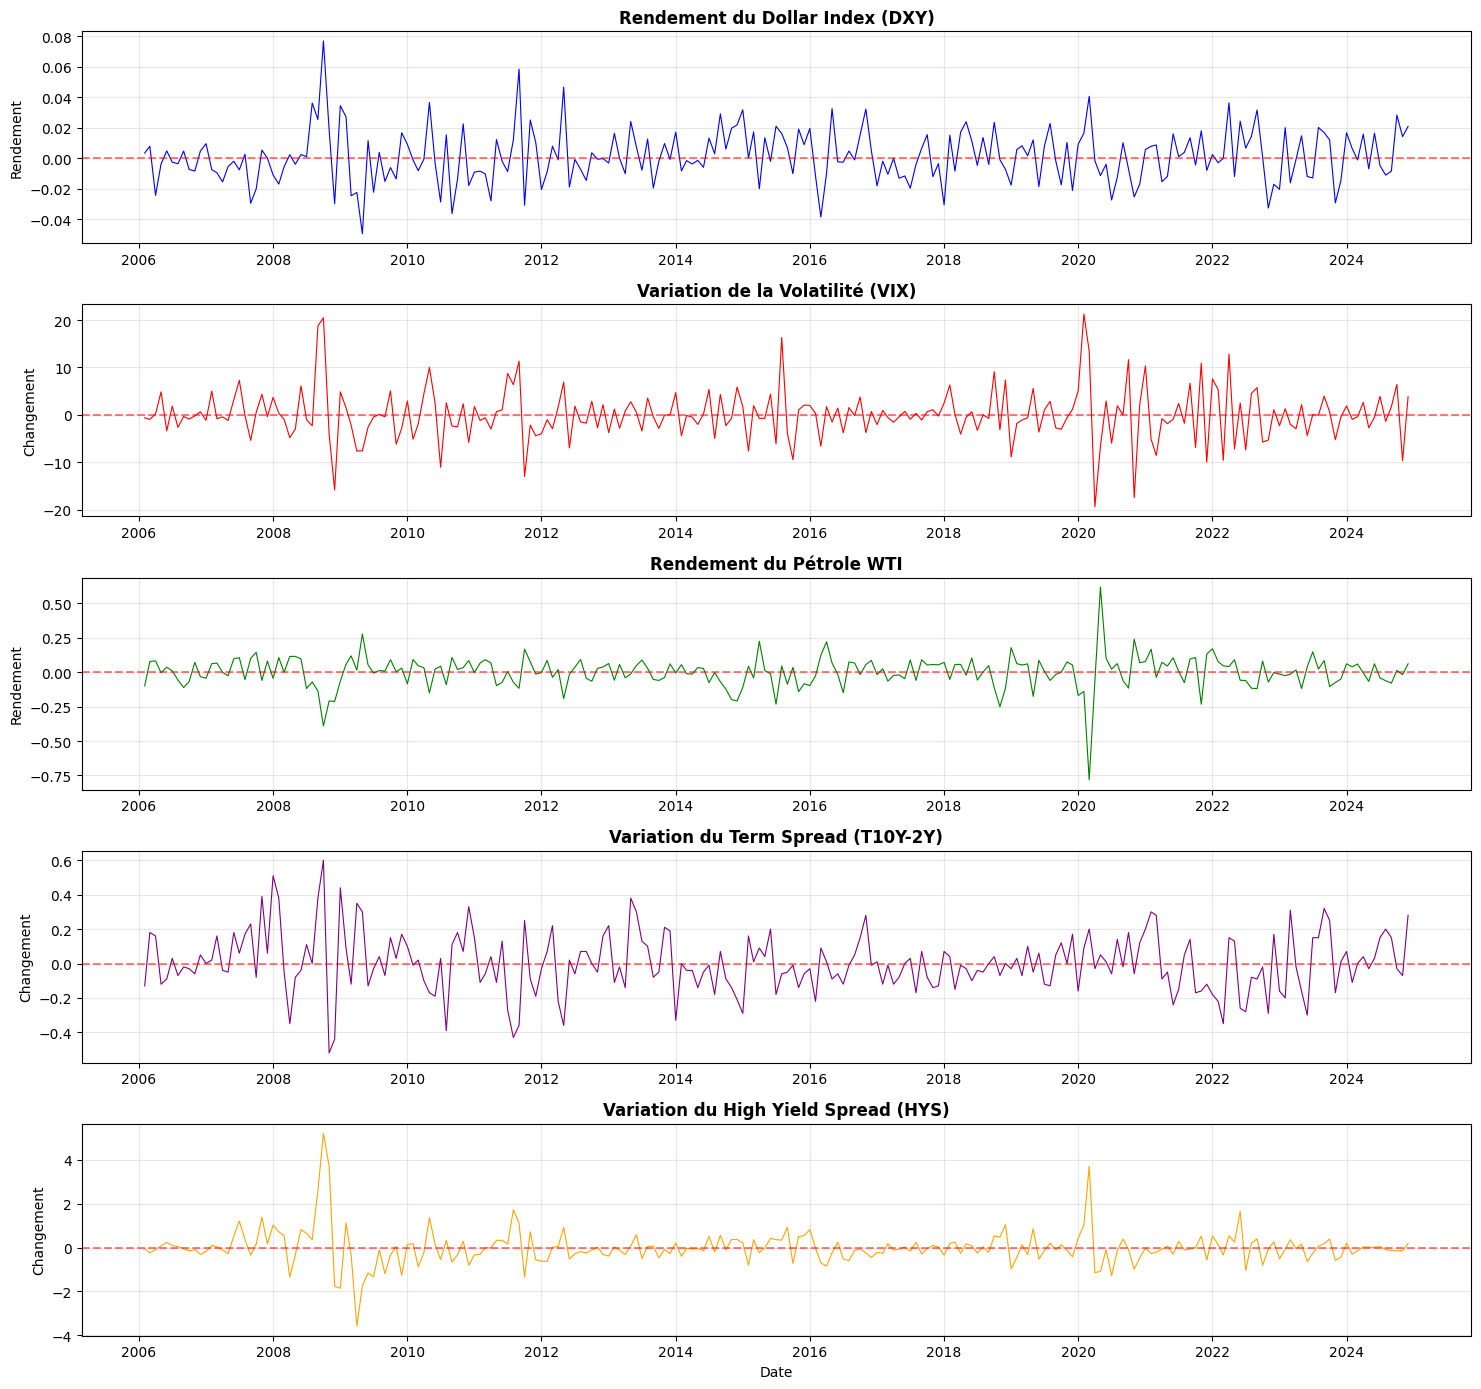

In [114]:
# Visualisation des 5 facteurs macroéconomiques
fig, axes = plt.subplots(5, 1, figsize=(15, 14))

# DXY Return
axes[0].plot(factor_data['date'], factor_data['DXY_return'], color='blue', linewidth=0.8)
axes[0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0].set_title('Rendement du Dollar Index (DXY)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Rendement')
axes[0].grid(True, alpha=0.3)

# VIX Change
axes[1].plot(factor_data['date'], factor_data['VIX_change'], color='red', linewidth=0.8)
axes[1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[1].set_title('Variation de la Volatilité (VIX)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Changement')
axes[1].grid(True, alpha=0.3)

# WTI Return
axes[2].plot(factor_data['date'], factor_data['WTI_return'], color='green', linewidth=0.8)
axes[2].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[2].set_title('Rendement du Pétrole WTI', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Rendement')
axes[2].grid(True, alpha=0.3)

# T10Y Change
axes[3].plot(factor_data['date'], factor_data['T10Y_change'], color='purple', linewidth=0.8)
axes[3].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[3].set_title('Variation du Term Spread (T10Y-2Y)', fontsize=12, fontweight='bold')
axes[3].set_ylabel('Changement')
axes[3].grid(True, alpha=0.3)

# HYS Change
axes[4].plot(factor_data['date'], factor_data['HYS_change'], color='orange', linewidth=0.8)
axes[4].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[4].set_title('Variation du High Yield Spread (HYS)', fontsize=12, fontweight='bold')
axes[4].set_ylabel('Changement')
axes[4].set_xlabel('Date')
axes[4].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Test Individuel des Facteurs

In [115]:
# Fonction pour estimer un modèle factoriel
def estimate_factor_model(y, X, currency_name, factor_names):
    
    # Ajouter une constante
    X_with_const = sm.add_constant(X)
    
    # Estimer le modèle
    model = sm.OLS(y, X_with_const)
    results = model.fit()
    
    return {
        'currency': currency_name,
        'model': results,
        'r_squared': results.rsquared,
        'adj_r_squared': results.rsquared_adj,
        'aic': results.aic,
        'bic': results.bic,
        'coefficients': results.params,
        'pvalues': results.pvalues,
        'residuals': results.resid
    }

In [120]:
# 3b) TESTS INDIVIDUELS DES FACTEURS

# Liste des facteurs à tester
factors_list = [('DXY_return', 'DXY'), ('VIX_change', 'VIX'), ('WTI_return', 'WTI'), 
                ('T10Y_change', 'T10Y'), ('HYS_change', 'HYS')]

# Tester chaque facteur individuellement
individual_results = {}
for factor_col, factor_name in factors_list:
    individual_results[factor_name] = {}
    for curr in currencies:
        y = factor_data[f'{curr}_return']
        X_single = factor_data[[factor_col]]
        result = estimate_factor_model(y, X_single, curr, [factor_name])
        individual_results[factor_name][curr] = result

# Tableau récapitulatif
summary_individual = pd.DataFrame({
    'Devise': currencies,
    'DXY': [individual_results['DXY'][c]['adj_r_squared'] for c in currencies],
    'VIX': [individual_results['VIX'][c]['adj_r_squared'] for c in currencies],
    'WTI': [individual_results['WTI'][c]['adj_r_squared'] for c in currencies],
    'T10Y': [individual_results['T10Y'][c]['adj_r_squared'] for c in currencies],
    'HYS': [individual_results['HYS'][c]['adj_r_squared'] for c in currencies]
})

print("\nRÉSULTATS: R^2 AJUSTÉ PAR FACTEUR")
summary_individual


RÉSULTATS: R^2 AJUSTÉ PAR FACTEUR


,Devise,DXY,VIX,WTI,T10Y,HYS
0,AUD,0.728798,0.316472,0.178023,-0.001487,0.293996
1,CAD,0.636074,0.223120,0.229969,0.001337,0.331398
2,JPY,0.093694,0.003634,0.012548,-0.003975,0.017880
3,NZD,0.630876,0.236730,0.108724,-0.004258,0.200896
4,GBP,0.496839,0.125260,0.140312,0.014403,0.206588


In [116]:
# Moyennes et classement
means = summary_individual[['DXY', 'VIX', 'WTI', 'T10Y', 'HYS']].mean()

means

DXY     0.517256
VIX     0.181043
WTI     0.133915
T10Y    0.001204
HYS     0.210151
dtype: float64

### 3c) Modèles Factoriels Multivariés - Approche Parcimonieuse (2-3 Facteurs Maximum)

**Spécifications testées:**

**Modèles à 2 facteurs:**
1. DXY + VIX (dollar + volatilité)
2. DXY + HYS (dollar + risque crédit)
3. DXY + WTI (dollar + pétrole)

**Modèles à 3 facteurs:**
4. DXY + VIX + WTI (modèle original aligné avec 3 composantes ACP)
5. DXY + VIX + HYS (dollar + double dimension de risque)
6. DXY + HYS + WTI (dollar + risque crédit + pétrole)

In [ ]:
# 3c) MODÈLES MULTIFACTORIELS - Tests de 2 à 3 facteurs

print("MODÈLES À 2 FACTEURS")

# Dictionnaire pour stocker tous les résultats
all_results = {}

# Tester 3 combinaisons à 2 facteurs
models_2f = [
    (['DXY_return', 'VIX_change'], ['DXY', 'VIX'], 'DXY+VIX'),
    (['DXY_return', 'HYS_change'], ['DXY', 'HYS'], 'DXY+HYS'),
    (['DXY_return', 'WTI_return'], ['DXY', 'WTI'], 'DXY+WTI')
]

for X_cols, factor_names, model_name in models_2f:
    X = factor_data[X_cols]
    results = {}
    for curr in currencies:
        y = factor_data[f'{curr}_return']
        results[curr] = estimate_factor_model(y, X, curr, factor_names)
    all_results[model_name] = results
    avg_r2 = np.mean([results[c]['adj_r_squared'] for c in currencies])
    print(f"{model_name:12s}: R^2 moyen = {avg_r2:.4f}")


print("MODÈLES À 3 FACTEURS")

# Tester 3 combinaisons à 3 facteurs
models_3f = [
    (['DXY_return', 'VIX_change', 'WTI_return'], ['DXY', 'VIX', 'WTI'], 'DXY+VIX+WTI'),
    (['DXY_return', 'VIX_change', 'HYS_change'], ['DXY', 'VIX', 'HYS'], 'DXY+VIX+HYS'),
    (['DXY_return', 'HYS_change', 'WTI_return'], ['DXY', 'HYS', 'WTI'], 'DXY+HYS+WTI')
]

for X_cols, factor_names, model_name in models_3f:
    X = factor_data[X_cols]
    results = {}
    for curr in currencies:
        y = factor_data[f'{curr}_return']
        results[curr] = estimate_factor_model(y, X, curr, factor_names)
    all_results[model_name] = results
    avg_r2 = np.mean([results[c]['adj_r_squared'] for c in currencies])
    print(f"{model_name:15s}: R^2 moyen = {avg_r2:.4f}")

MODÈLES À 2 FACTEURS
DXY+VIX     : R^2 moyen = 0.5398
DXY+HYS     : R^2 moyen = 0.5540
DXY+WTI     : R^2 moyen = 0.5391
MODÈLES À 3 FACTEURS
DXY+VIX+WTI    : R^2 moyen = 0.5563
DXY+VIX+HYS    : R^2 moyen = 0.5609
DXY+HYS+WTI    : R^2 moyen = 0.5598


In [125]:
# COMPARAISON ET SÉLECTION DU MODÈLE OPTIMAL

# Créer tableau comparatif
comparison_all = pd.DataFrame({
    'Devise': currencies,
    'DXY+VIX': [all_results['DXY+VIX'][c]['adj_r_squared'] for c in currencies],
    'DXY+HYS': [all_results['DXY+HYS'][c]['adj_r_squared'] for c in currencies],
    'DXY+WTI': [all_results['DXY+WTI'][c]['adj_r_squared'] for c in currencies],
    'DXY+VIX+WTI': [all_results['DXY+VIX+WTI'][c]['adj_r_squared'] for c in currencies],
    'DXY+VIX+HYS': [all_results['DXY+VIX+HYS'][c]['adj_r_squared'] for c in currencies],
    'DXY+HYS+WTI': [all_results['DXY+HYS+WTI'][c]['adj_r_squared'] for c in currencies]
})

comparison_all


,Devise,DXY+VIX,DXY+HYS,DXY+WTI,DXY+VIX+WTI,DXY+VIX+HYS,DXY+HYS+WTI
0,AUD,0.750491,0.738243,0.730042,0.750055,0.750997,0.737187
1,CAD,0.640908,0.666255,0.654462,0.656393,0.664760,0.671062
2,JPY,0.174214,0.231797,0.181485,0.238715,0.247413,0.257993
3,NZD,0.638965,0.630148,0.629733,0.638832,0.637573,0.629857
4,GBP,0.494594,0.503520,0.499710,0.497621,0.503599,0.502765


In [ ]:

# Statistiques par modèle
model_stats = pd.DataFrame({
    'Modèle': list(comparison_all.columns[1:]),
    'R^2 Moyen': [comparison_all[col].mean() for col in comparison_all.columns[1:]],
    'Nb Facteurs': [2, 2, 2, 3, 3, 3]
}).sort_values('R^2 Moyen', ascending=False).reset_index(drop=True)

print("\n" + "-" * 80)
print(model_stats.to_string(index=False))

# Sélection du meilleur modèle
best_model_name = 'DXY+HYS'
best_r2 = comparison_all['DXY+HYS'].mean()

print(f"Modèle: {best_model_name}")
print(f"R^2 Ajusté Moyen: {best_r2:.4f}")



--------------------------------------------------------------------------------
     Modèle  R^2 Moyen  Nb Facteurs
DXY+VIX+HYS   0.560868            3
DXY+HYS+WTI   0.559773            3
DXY+VIX+WTI   0.556323            3
    DXY+HYS   0.553993            2
    DXY+VIX   0.539834            2
    DXY+WTI   0.539086            2
Modèle: DXY+HYS
R² Ajusté Moyen: 0.5540


### 3d) Analyse Détaillée du Modèle Optimal

In [133]:
# Identifier le modèle optimal basé sur les résultats de la section 3c

# Récupérer les résultats du modèle optimal (DXY + HYS)
optimal_results = all_results['DXY+HYS']
optimal_factors = ['DXY', 'HYS']
num_factors = 2

# Créer un tableau des coefficients
coef_data = {'Devise': currencies}
coef_data['Intercept'] = [optimal_results[c]['coefficients']['const'] for c in currencies]

for factor in optimal_factors:
    if factor == 'DXY':
        coef_data[f'β_{factor}'] = [optimal_results[c]['coefficients']['DXY_return'] for c in currencies]
    elif factor == 'VIX':
        coef_data[f'β_{factor}'] = [optimal_results[c]['coefficients']['VIX_change'] for c in currencies]
    elif factor == 'WTI':
        coef_data[f'β_{factor}'] = [optimal_results[c]['coefficients']['WTI_return'] for c in currencies]
    elif factor == 'HYS':
        coef_data[f'β_{factor}'] = [optimal_results[c]['coefficients']['HYS_change'] for c in currencies]

coef_table = pd.DataFrame(coef_data)

coef_table

,Devise,Intercept,β_DXY,β_HYS
0,AUD,-0.001003,1.638612,0.005546
1,CAD,-0.000147,1.012053,0.006810
2,JPY,0.000256,0.876776,-0.015516
3,NZD,-0.001099,1.717607,0.001737
4,GBP,0.000452,0.954210,0.003607


In [137]:
# Tableau de significativité des coefficients

pval_data = {'Devise': currencies}
for factor in optimal_factors:
    if factor == 'DXY':
        pval_data[f'{factor}'] = [optimal_results[c]['pvalues']['DXY_return'] for c in currencies]
    elif factor == 'VIX':
        pval_data[f'{factor}'] = [optimal_results[c]['pvalues']['VIX_change'] for c in currencies]
    elif factor == 'WTI':
        pval_data[f'{factor}'] = [optimal_results[c]['pvalues']['WTI_return'] for c in currencies]
    elif factor == 'HYS':
        pval_data[f'{factor}'] = [optimal_results[c]['pvalues']['HYS_change'] for c in currencies]

pval_table = pd.DataFrame(pval_data)

pval_table

,Devise,DXY,HYS
0,AUD,2.222071e-50,2.823058e-03
1,CAD,7.255386e-36,6.465144e-06
2,JPY,7.612543e-14,7.270606e-10
3,NZD,1.477987e-39,4.561191e-01
4,GBP,8.231958e-25,4.596777e-02


In [ ]:
# Tableau récapitulatif de la performance

perf_table = pd.DataFrame({
    'Devise': currencies,
    'R^2': [optimal_results[c]['r_squared'] for c in currencies],
    'R^2 Ajusté': [optimal_results[c]['adj_r_squared'] for c in currencies],
    'AIC': [optimal_results[c]['aic'] for c in currencies],
    'BIC': [optimal_results[c]['bic'] for c in currencies]
})

perf_table

,Devise,R^2,R^2 Ajusté,AIC,BIC
0,AUD,0.740559,0.738243,-1163.332583,-1153.057733
1,CAD,0.669208,0.666255,-1263.190763,-1252.915913
2,JPY,0.238596,0.231797,-1039.957613,-1029.682763
3,NZD,0.633421,0.630148,-1055.966211,-1045.691361
4,GBP,0.507913,0.503520,-1173.144954,-1162.870104


### 3e) Qualité du Modèle et Données Manquantes

Nous évaluons maintenant la qualité du modèle DXY + HYS et identifions les données additionnelles qui pourraient l'améliorer.

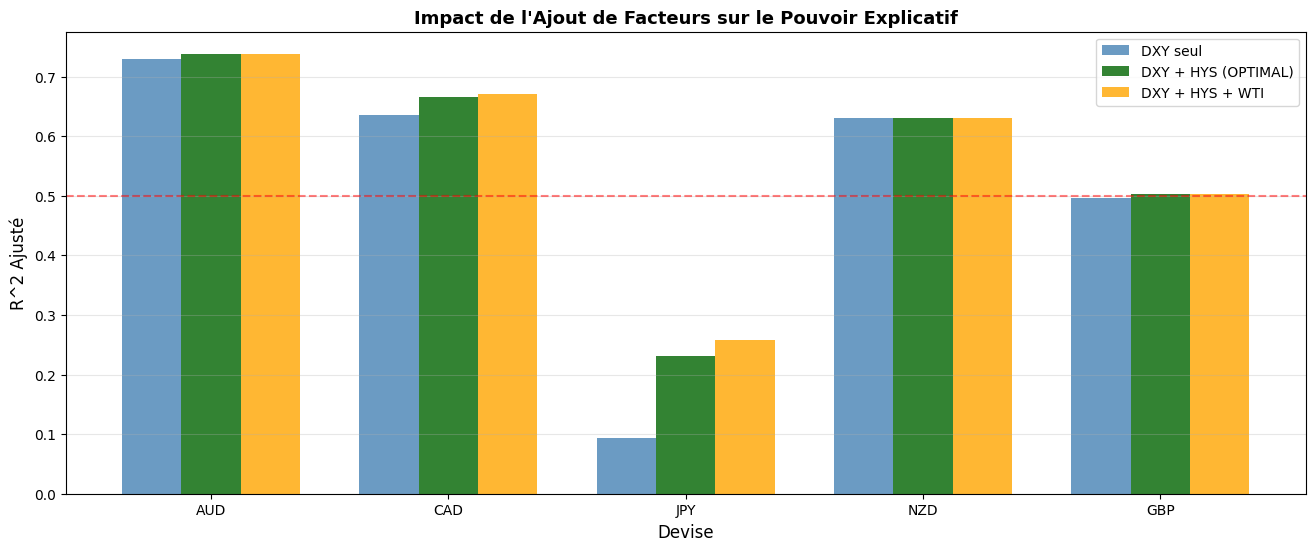

In [ ]:
# Visualisation de la progression du R^2
fig, ax1 = plt.subplots(1, 1, figsize=(16, 6))

# Graphique 1: Evolution du R^2 par devise
x_pos = np.arange(len(currencies))
width = 0.25

r2_dxy = [individual_results['DXY'][c]['adj_r_squared'] for c in currencies]
r2_dxy_hys = [all_results['DXY+HYS'][c]['adj_r_squared'] for c in currencies]
r2_dxy_hys_wti = [all_results['DXY+HYS+WTI'][c]['adj_r_squared'] for c in currencies]

ax1.bar(x_pos - width, r2_dxy, width, label='DXY seul', alpha=0.8, color='steelblue')
ax1.bar(x_pos, r2_dxy_hys, width, label='DXY + HYS (OPTIMAL)', alpha=0.8, color='darkgreen')
ax1.bar(x_pos + width, r2_dxy_hys_wti, width, label='DXY + HYS + WTI', alpha=0.8, color='orange')

ax1.set_xlabel('Devise', fontsize=12)
ax1.set_ylabel('R^2 Ajusté', fontsize=12)
ax1.set_title('Impact de l\'Ajout de Facteurs sur le Pouvoir Explicatif', fontsize=13, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(currencies)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')
ax1.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Seuil 50%')
